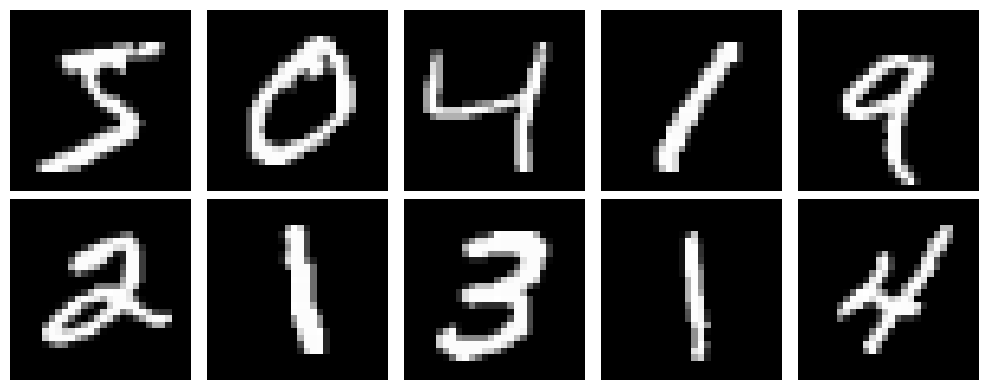

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets.mnist import load_data
import numpy as np

(X_train, y_train), (X_test, y_test) = load_data()
y_train, y_test = y_train.ravel(), y_test.ravel()

def plot_samples(data):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")
    fig.tight_layout()

plot_samples(X_train)


In [22]:

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
print(f"{X_train.min()=}, {X_train.max()=}")

X_train.min()=0.0, X_train.max()=1.0


## Train|val|test split

In [23]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=1 / 6, random_state=42
)

In [24]:
# ImageDataGenerator requires rank 4 
X_train_val = X_train_val[:,:,:,None]
X_val = X_val[:,:,:,None]
X_train = X_train[:,:,:,None]
X_test = X_test[:,:,:,None]

X_train_val.shape

(50000, 28, 28, 1)

<div style="max-width:66ch;">

## Data augmentation

Deep learning models require lots of data to be trained on and a cheap way to get a lot of data is to augment existing one. This can be done through flipping, rotating, scaling, addin noise, randomly cropping, zooming in randomly, adding colors, removing information, change contrast etc. 

- ImageDataGenerator to augment images

</div>

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    height_shift_range=0.2,
    width_shift_range=0.2,
)
# don't augment test data and validation data as we want to test on original data
# we just instantiate an ImageDataGenerator without augmentation
test_image_generator = ImageDataGenerator()

# batch size 32 for mini-batch gradient descent 
train_val_generator = train_image_generator.flow(
    X_train_val, y_train_val, batch_size=32
)

# batch size 32 for mini-batch gradient descent 
train_generator = train_image_generator.flow(
    X_train, y_train, batch_size=32
)

val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

# NumpyArrayIterator
train_val_generator, val_generator

(<keras.src.legacy.preprocessing.image.NumpyArrayIterator at 0x7eeaf0f3e110>,
 <keras.src.legacy.preprocessing.image.NumpyArrayIterator at 0x7eea470846d0>)

2
(32, 28, 28, 1)


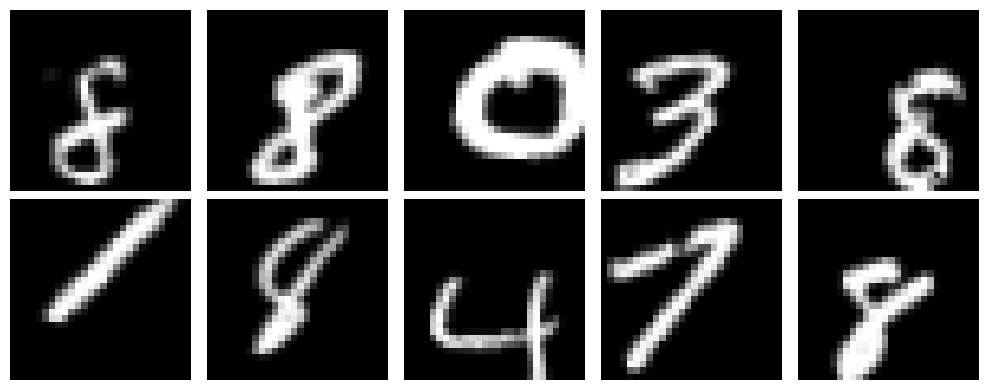

In [27]:
# Använda next() funktionen från Python standardbibliotek
print(len(next(train_val_generator)))  # tuple of (X_train_val, y_train_val)
print(next(train_val_generator)[0].shape)  # 32 samples in a batch of images of shape (32,32,3)

# Nu använder vi också en loop för att plotta exempelbilder
batch = next(train_val_generator)[0]  # Hämta nästa parti (batch) bilder
plot_samples(batch)


<div style="max-width:66ch;">

## CNN model

</div>

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate=0.001, drop_rate=0.5, kernels=[32, 32]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel,
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=X_train.shape[1:],
        )

        model.add(conv_layer)
        # defaults to pool_size if None
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["acc"]
    )

    return model

model = CNN_model(drop_rate=.5)

model.summary()



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,194 (848.41 KB)

 Trainable params: 217,194 (848.41 KB)

 Non-trainable params: 0 (0.00 B)

<div style="max-width:66ch;">

## Train on augmented data

 - steps_per_epoch is the number of times we generate our data from the generator
 - since we have batches on 32 samples for each time we generate, we could count how many samples before we cover original data size
 - 50000/32 = 

</div>

In [29]:
steps_per_epochs = len(X_train_val)/32
validation_steps = len(X_val)/32

steps_per_epochs, validation_steps


(1562.5, 312.5)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(
    monitor="val_acc", mode="max", patience=5, restore_best_weights=True
)

model.fit(
    train_val_generator,
    steps_per_epoch=1500,
    epochs=100,
    callbacks=[early_stopper],
    validation_data=val_generator,
    validation_steps=312,
)


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  14/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - acc: 0.1273 - loss: 2.4175

I0000 00:00:1714643556.366592     136 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714643556.384656     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.6472 - loss: 1.0389

W0000 00:00:1714643580.331844     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - acc: 0.6473 - loss: 1.0386 - val_acc: 0.9678 - val_loss: 0.1096
Epoch 2/100
  56/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - acc: 0.9123 - loss: 0.2901

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - acc: 0.9089 - loss: 0.3000 - val_acc: 1.0000 - val_loss: 0.0518
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - acc: 0.9173 - loss: 0.2612 - val_acc: 0.9751 - val_loss: 0.0832
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step - acc: 0.9247 - loss: 0.2443 - val_acc: 1.0000 - val_loss: 0.0490
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - acc: 0.9342 - loss: 0.2036 - val_acc: 0.9805 - val_loss: 0.0645
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step - acc: 0.9439 - loss: 0.1603 - val_acc: 1.0000 - val_loss: 0.0036
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - acc: 0.9447 - loss: 0.1762 - val_acc: 0.9780 - val_loss: 0.0755


In [31]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,acc,loss,val_acc,val_loss
0,0.792077,0.633176,0.967849,0.109631
1,0.908730,0.300400,1.000000,0.051819
2,0.921036,0.248148,0.975060,0.083215
3,0.924603,0.243870,1.000000,0.049020
4,0.935749,0.201253,0.980469,0.064545


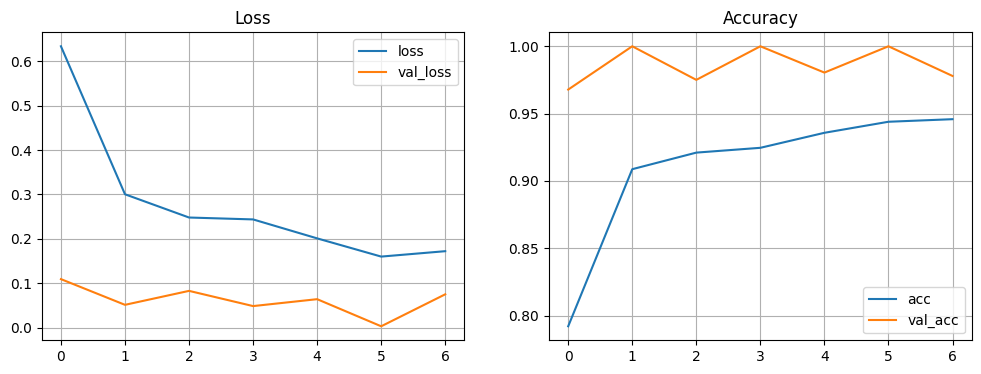

In [32]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)

plot_metrics(metrics)
# val accuracy is higher than train accuracy, probably due to train data being
# augmented, which gives a lot of varieties in data and is harder to overfit

## Train on all training data

In [33]:
model = CNN_model()
model.fit(
    train_generator,
    steps_per_epoch=1500,
    epochs=30,
)


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  14/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - acc: 0.1062 - loss: 2.6333

W0000 00:00:1714643663.031229     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - acc: 0.6467 - loss: 1.0492
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9017 - loss: 0.3103  
Epoch 3/30
   1/1500 ━━━━━━━━━━━━━━━━━━━━ 3:16 131ms/step - acc: 0.8438 - loss: 0.4578

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - acc: 0.9165 - loss: 0.2669
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9344 - loss: 0.2040  
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - acc: 0.9364 - loss: 0.2006
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9466 - loss: 0.1673  
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - acc: 0.9466 - loss: 0.1727
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9521 - loss: 0.1499  
Epoch 9/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - acc: 0.9513 - loss: 0.1542
Epoch 10/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9531 - loss: 0.1477  
Epoch 11/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - acc: 0.9571 - loss: 0.1359
Epoch 12/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9558 - loss: 0.1368  
Epoch 13/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - acc: 0.9586 - loss: 0.1309
Epoch 14/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9619 - l

109/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1714644040.171275     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.97      1.00      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.97      1.00      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



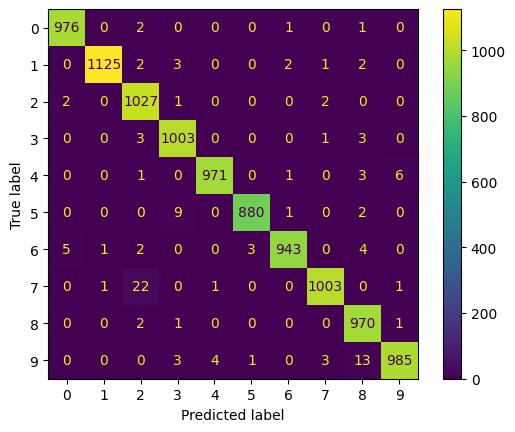

In [34]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

y_pred = model.predict(X_test)
#y_pred = np.argmax(y_pred)

y_pred = np.argmax(y_pred, axis = 1)


print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()